In [1]:
!unzip '/content/diyabet.zip'

Archive:  /content/diyabet.zip
   creating: diyabet/
  inflating: diyabet/diabetes.csv    


In [ ]:
!pip install catboost -q

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


In [ ]:
# =============================================================================
# VERİ YÜKLEME VE ÖN İŞLEME
# =============================================================================
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

dosya_yolu = "/content/diyabet/diabetes.csv"

try:
    df = pd.read_csv(dosya_yolu)
    print(f"Başarılı! Veri Seti Boyutu: {df.shape}")

    target_col = 'Outcome'
    print(f"Hedef Sütun: {target_col}")

    zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    df[zero_cols] = df[zero_cols].replace(0, np.nan)

    print(f"Eksik veriler (0 yerine NaN atandıktan sonra): \n{df.isnull().sum()[zero_cols]}")

    num_cols = df.columns.drop(target_col)

    imputer = SimpleImputer(strategy='median')
    df[num_cols] = imputer.fit_transform(df[num_cols])

    le = LabelEncoder()
    df[target_col] = le.fit_transform(df[target_col])

    print("-" * 30)
    print("Veri temizlendi ve 0 olan hatalı değerler medyan ile dolduruldu.")

except FileNotFoundError:
    print(f"HATA: '{dosya_yolu}' bulunamadı. Dosyayı Colab'e yüklediğinden ve ismin doğru olduğundan emin ol.")
except Exception as e:
    print(f"Beklenmeyen bir hata oluştu: {e}")

Başarılı! Veri Seti Boyutu: (2012, 9)
Hedef Sütun: Outcome
Eksik veriler (0 yerine NaN atandıktan sonra): 
Glucose            5
BloodPressure     37
SkinThickness    238
Insulin          565
BMI               13
dtype: int64
------------------------------
Veri temizlendi ve 0 olan hatalı değerler medyan ile dolduruldu.


In [ ]:
# =============================================================================
# ÖZELLİK MÜHENDİSLİĞİ (Medical Feature Engineering)
# =============================================================================
data = df.copy()

def get_bmi_category(bmi):
    if bmi < 18.5: return 0 # Underweight
    elif bmi < 25: return 1 # Normal
    elif bmi < 30: return 2 # Overweight
    else: return 3          # Obese

data['BMI_Cat'] = data['BMI'].apply(get_bmi_category)

data['Insulin_Glucose_Ratio'] = data['Insulin'] / (data['Glucose'] + 0.1)

data['Age_BP_Interaction'] = data['Age'] * data['BloodPressure']

data['DPF_Log'] = np.log1p(data['DiabetesPedigreeFunction'])

print("--- Tıbbi Özellik Mühendisliği Tamamlandı ---")
print(f"Son Veri Boyutu: {data.shape}")

corr_matrix = data.corr()
print("\nHedef Değişken (Outcome) ile Korelasyonlar:")
print(corr_matrix['Outcome'].sort_values(ascending=False))

print("\nİlk 5 Satır:")
print(data.head())

--- Tıbbi Özellik Mühendisliği Tamamlandı ---
Son Veri Boyutu: (2012, 13)

Hedef Değişken (Outcome) ile Korelasyonlar:
Outcome                     1.000000
Glucose                     0.691934
Age_BP_Interaction          0.663456
Age                         0.647182
BMI                         0.598349
BMI_Cat                     0.597787
BloodPressure               0.578830
DPF_Log                     0.543598
SkinThickness               0.539447
Pregnancies                 0.521688
DiabetesPedigreeFunction    0.509476
Insulin                     0.470819
Insulin_Glucose_Ratio       0.123797
Name: Outcome, dtype: float64

İlk 5 Satır:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          6.0    148.0           72.0           35.0    155.0  33.6   
1          1.0     85.0           66.0           29.0    155.0  26.6   
2          8.0    183.0           64.0           29.0    155.0  23.3   
3          1.0     89.0           66.0           23.0     94.0  28.1

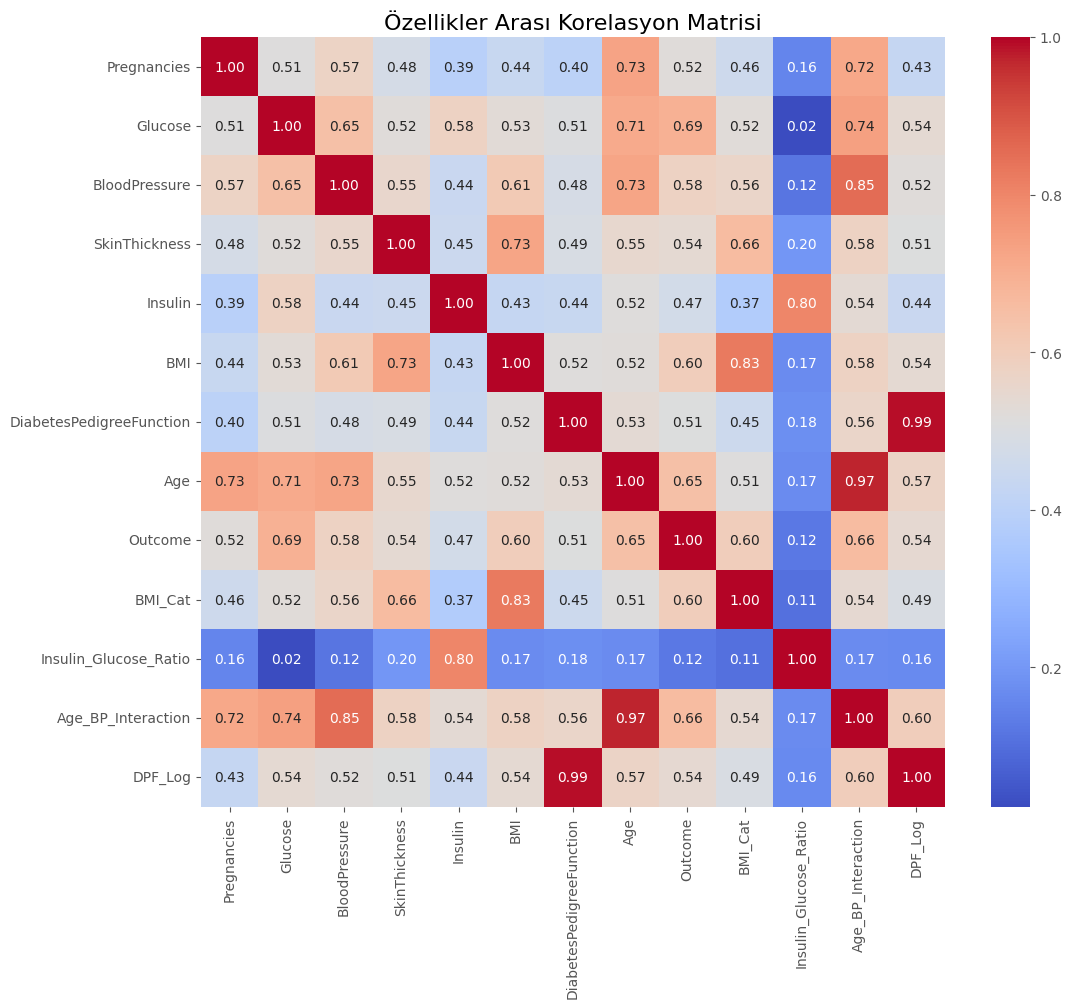

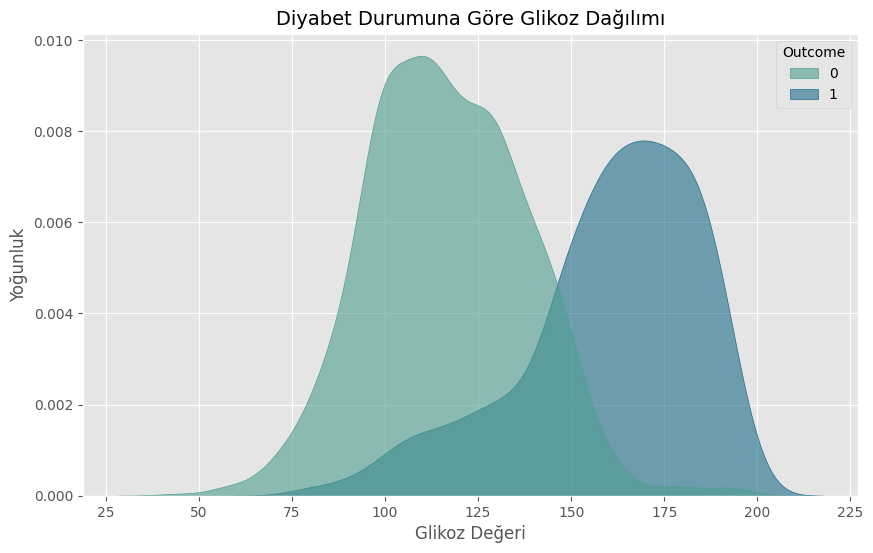

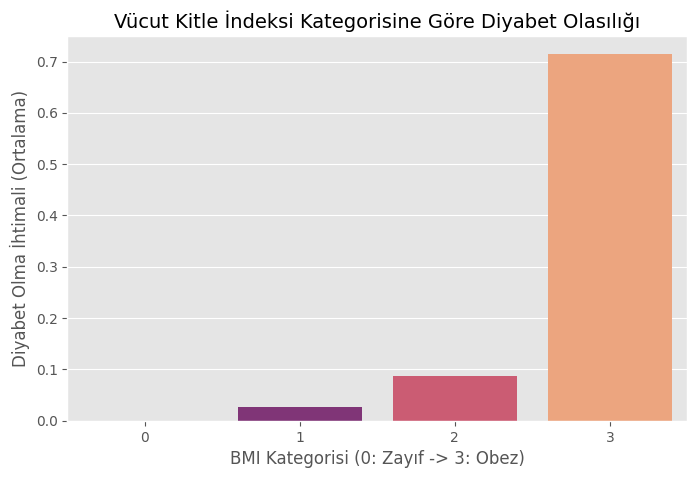

In [ ]:
# =============================================================================
# VERİ GÖRSELLEŞTİRME (EDA)
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Özellikler Arası Korelasyon Matrisi", fontsize=16)
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x="Glucose", hue="Outcome", fill=True, palette="crest", alpha=0.6)
plt.title("Diyabet Durumuna Göre Glikoz Dağılımı", fontsize=14)
plt.xlabel("Glikoz Değeri")
plt.ylabel("Yoğunluk")
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(x="BMI_Cat", y="Outcome", data=data, palette="magma", errorbar=None)
plt.title("Vücut Kitle İndeksi Kategorisine Göre Diyabet Olasılığı", fontsize=14)
plt.xlabel("BMI Kategorisi (0: Zayıf -> 3: Obez)")
plt.ylabel("Diyabet Olma İhtimali (Ortalama)")
plt.show()

In [ ]:
# =============================================================================
# VERİ SETİNİ AYIRMA (Train / Test Split)
# =============================================================================
from sklearn.model_selection import train_test_split

X = data.drop(columns=['Outcome'])
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    shuffle=True,
    stratify=y
)
print(f"Eğitim Seti Boyutu: {X_train.shape}")
print(f"Test Seti Boyutu  : {X_test.shape}")

print("\n--- Dağılım Kontrolü (Oranlar Eşit mi?) ---")
print("Eğitim Seti Oranları:\n", y_train.value_counts(normalize=True))
print("Test Seti Oranları:  \n", y_test.value_counts(normalize=True))

Eğitim Seti Boyutu: (1609, 12)
Test Seti Boyutu  : (403, 12)

--- Dağılım Kontrolü (Oranlar Eşit mi?) ---
Eğitim Seti Oranları:
 Outcome
0    0.556868
1    0.443132
Name: proportion, dtype: float64
Test Seti Oranları:  
 Outcome
0    0.555831
1    0.444169
Name: proportion, dtype: float64


CatBoost modeli hastalık verisi üzerinde eğitiliyor...
Eğitim tamamlandı.

===== CATBOOST SONUÇLARI =====
Doğruluk (Accuracy): %89.58
F1 Skoru           : %87.93

--- Detaylı Sınıflandırma Raporu ---
              precision    recall  f1-score   support

Sağlıklı (0)       0.89      0.93      0.91       224
 Diyabet (1)       0.91      0.85      0.88       179

    accuracy                           0.90       403
   macro avg       0.90      0.89      0.89       403
weighted avg       0.90      0.90      0.90       403



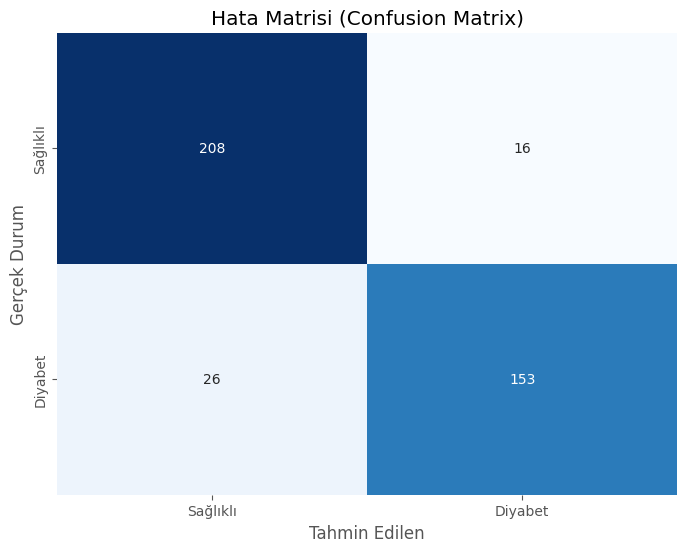

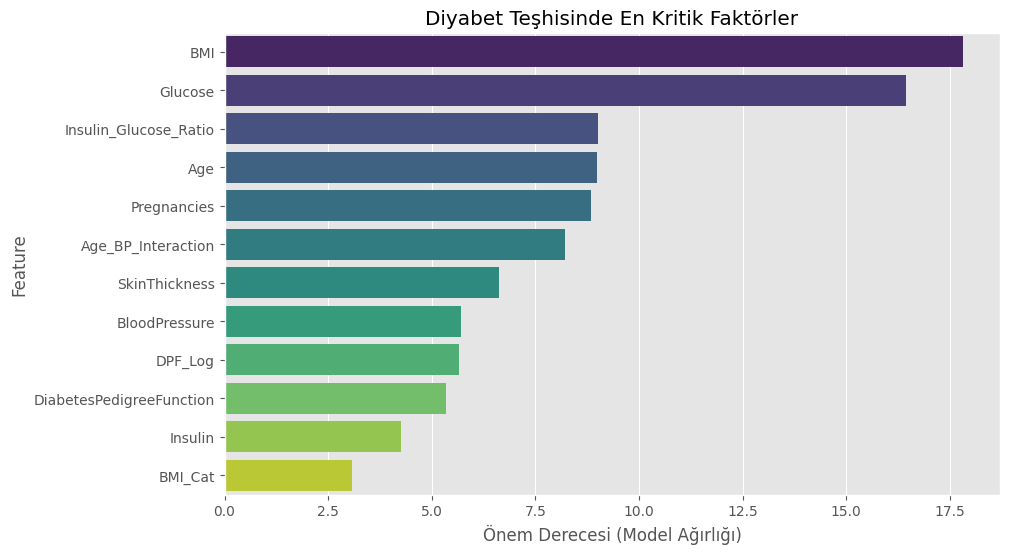

In [ ]:
# =============================================================================
# CATBOOST MODELİ EĞİTİMİ VE SONUÇ ANALİZİ (Diyabet)
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

cb_model = CatBoostClassifier(iterations=500,
                              learning_rate=0.05,
                              depth=6,
                              random_state=42,
                              verbose=0)

print("CatBoost modeli hastalık verisi üzerinde eğitiliyor...")
cb_model.fit(X_train, y_train)
print("Eğitim tamamlandı.\n")

y_pred = cb_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"===== CATBOOST SONUÇLARI =====")
print(f"Doğruluk (Accuracy): %{acc * 100:.2f}")
print(f"F1 Skoru           : %{f1 * 100:.2f}")
print("\n--- Detaylı Sınıflandırma Raporu ---")
print(classification_report(y_test, y_pred, target_names=['Sağlıklı (0)', 'Diyabet (1)']))

# =============================================================================
# GÖRSELLEŞTİRME 1: Karmaşıklık Matrisi (Hata Analizi)
# =============================================================================
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
# Tıbbi verilerde genellikle 'Blues' veya 'Reds' kullanılır.
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sağlıklı', 'Diyabet'],
            yticklabels=['Sağlıklı', 'Diyabet'])
plt.title('Hata Matrisi (Confusion Matrix)')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Durum')
plt.show()

# =============================================================================
# GÖRSELLEŞTİRME 2: Özellik Önem Düzeyleri (Feature Importance)
# =============================================================================
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': cb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Diyabet Teşhisinde En Kritik Faktörler')
plt.xlabel('Önem Derecesi (Model Ağırlığı)')
plt.show()


--- OPTİMİZASYON SONUCU ---
En İyi Parametreler: {'depth': 6, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Eğitim Setindeki Ortalama Başarı: %90.12

===== OPTİMİZE EDİLMİŞ TEST SONUÇLARI =====
Doğruluk (Accuracy): %89.33
              precision    recall  f1-score   support

    Sağlıklı       0.89      0.93      0.91       224
     Diyabet       0.90      0.85      0.88       179

    accuracy                           0.89       403
   macro avg       0.89      0.89      0.89       403
weighted avg       0.89      0.89      0.89       403



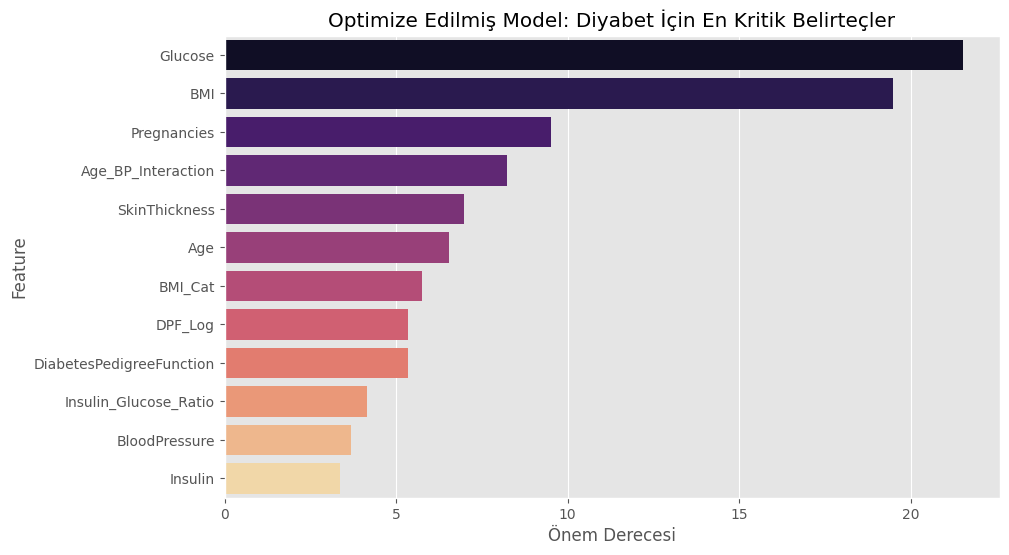

In [ ]:
# =============================================================================
# HİPERPARAMETRE OPTİMİZASYONU (Grid Search)
# =============================================================================
from sklearn.model_selection import GridSearchCV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

params = {
    'iterations': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6],
    'l2_leaf_reg': [1, 3, 5, 7]
}

cb = CatBoostClassifier(verbose=0, random_state=42)

grid_search = GridSearchCV(estimator=cb, param_grid=params, scoring='accuracy', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\n--- OPTİMİZASYON SONUCU ---")
print(f"En İyi Parametreler: {best_params}")
print(f"Eğitim Setindeki Ortalama Başarı: %{best_score * 100:.2f}")

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print(f"\n===== OPTİMİZE EDİLMİŞ TEST SONUÇLARI =====")
print(f"Doğruluk (Accuracy): %{accuracy_score(y_test, y_pred_best) * 100:.2f}")
print(classification_report(y_test, y_pred_best, target_names=['Sağlıklı', 'Diyabet']))

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='magma')
plt.title('Optimize Edilmiş Model: Diyabet İçin En Kritik Belirteçler')
plt.xlabel('Önem Derecesi')
plt.show()

In [ ]:
import numpy as np
import pandas as pd

final_model = best_model

def predict_new_patient(pregnancies, glucose, blood_pressure, skin_thickness, insulin, bmi, dpf, age):
    """
    Yeni bir hasta geldiğinde modelin nasıl karar verdiğini simüle eder.
    Otomatik Feature Engineering yapar.
    """

    if bmi < 18.5: bmi_cat = 0
    elif bmi < 25: bmi_cat = 1
    elif bmi < 30: bmi_cat = 2
    else: bmi_cat = 3

    # İnsülin / Glikoz Oranı (+0.1 sıfıra bölünme hatası için)
    insulin_glucose_ratio = insulin / (glucose + 0.1)

    # Yaş x Tansiyon
    age_bp_interaction = age * blood_pressure

    # DPF Logaritma
    dpf_log = np.log1p(dpf)

    input_data = pd.DataFrame({
        'Pregnancies': [pregnancies],
        'Glucose': [glucose],
        'BloodPressure': [blood_pressure],
        'SkinThickness': [skin_thickness],
        'Insulin': [insulin],
        'BMI': [bmi],
        'DiabetesPedigreeFunction': [dpf],
        'Age': [age],
        'BMI_Cat': [bmi_cat],
        'Insulin_Glucose_Ratio': [insulin_glucose_ratio],
        'Age_BP_Interaction': [age_bp_interaction],
        'DPF_Log': [dpf_log]
    })

    prediction = final_model.predict(input_data)[0]
    probability = final_model.predict_proba(input_data)[0][1]

    print(f"\n------------------------------------------------------")
    print(f"📋 HASTA PROFİLİ: Yaş: {age} | BMI: {bmi} | Şeker: {glucose}")
    print(f"------------------------------------------------------")

    if prediction == 1:
        print(f"🛑 TANI: DİYABET RİSKİ POZİTİF")
        print(f"📊 Güven Oranı: %{probability * 100:.2f}")
        print("⚠️  Durum ciddi görünüyor, detaylı klinik tetkik önerilir.")
    else:
        print(f"✅ TANI: NEGATİF (SAĞLIKLI)")
        print(f"📊 Diyabet İhtimali: Sadece %{probability * 100:.2f}")
        print("👍  Değerler normal aralıkta.")

# =============================================================================
# SENARYOLAR (Değerleri değiştirip oynayabilirsin)
# =============================================================================

# Senaryo 1: Riskli (Obez, Yüksek Şeker, Orta Yaş)
predict_new_patient(pregnancies=3, glucose=98, blood_pressure=85,
                    skin_thickness=30, insulin=200, bmi=38.5, dpf=0.8, age=50)

# Senaryo 2: Sınırda (Hafif Kilolu, Şeker Normal ama Aile Geçmişi Var)
predict_new_patient(pregnancies=0, glucose=110, blood_pressure=75,
                    skin_thickness=20, insulin=90, bmi=27.0, dpf=1.2, age=35)

# Senaryo 3: Sağlıklı
predict_new_patient(pregnancies=0, glucose=85, blood_pressure=60,
                    skin_thickness=15, insulin=60, bmi=21.0, dpf=0.3, age=22)


------------------------------------------------------
📋 HASTA PROFİLİ: Yaş: 50 | BMI: 38.5 | Şeker: 98
------------------------------------------------------
🛑 TANI: DİYABET RİSKİ POZİTİF
📊 Güven Oranı: %50.15
⚠️  Durum ciddi görünüyor, detaylı klinik tetkik önerilir.

------------------------------------------------------
📋 HASTA PROFİLİ: Yaş: 35 | BMI: 27.0 | Şeker: 110
------------------------------------------------------
✅ TANI: NEGATİF (SAĞLIKLI)
📊 Diyabet İhtimali: Sadece %10.11
👍  Değerler normal aralıkta.

------------------------------------------------------
📋 HASTA PROFİLİ: Yaş: 22 | BMI: 21.0 | Şeker: 85
------------------------------------------------------
✅ TANI: NEGATİF (SAĞLIKLI)
📊 Diyabet İhtimali: Sadece %0.45
👍  Değerler normal aralıkta.


In [ ]:
# =============================================================================
# ADIM 6: MODELİ DİSKTE SAKLAMA (SAVE)
# =============================================================================
import joblib

# 'best_model' bizim GridSearch'ten bulduğumuz en iyi modeldi.
# Bunu 'diyabet_modeli.pkl' adıyla kaydediyoruz.
joblib.dump(best_model, 'diyabet_modeli.pkl')

print("✅ Model başarıyla kaydedildi: diyabet_modeli.pkl")
print("Artık bilgisayarı kapatsan bile modelin bu dosyada saklı kalacak.")

✅ Model başarıyla kaydedildi: diyabet_modeli.pkl
Artık bilgisayarı kapatsan bile modelin bu dosyada saklı kalacak.


# **EXTRA TREES**




In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.3 MB/s eta 0:00:00


Bayesian Optimization Başlatılıyor... (Akıllı Arama)

--- BAYESIAN OPTİMİZASYON SONUCU ---
En İyi Parametreler: OrderedDict({'bootstrap': False, 'criterion': 'entropy', 'max_depth': 17, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 104})
Eğitim Setindeki En İyi Skor: %90.86

===== OPTİMİZE EXTRA TREES SONUÇLARI =====
Doğruluk (Accuracy): %89.08
F1 Skoru           : %87.28

--- Detaylı Rapor ---
              precision    recall  f1-score   support

    Sağlıklı       0.88      0.93      0.90       224
     Diyabet       0.90      0.84      0.87       179

    accuracy                           0.89       403
   macro avg       0.89      0.89      0.89       403
weighted avg       0.89      0.89      0.89       403



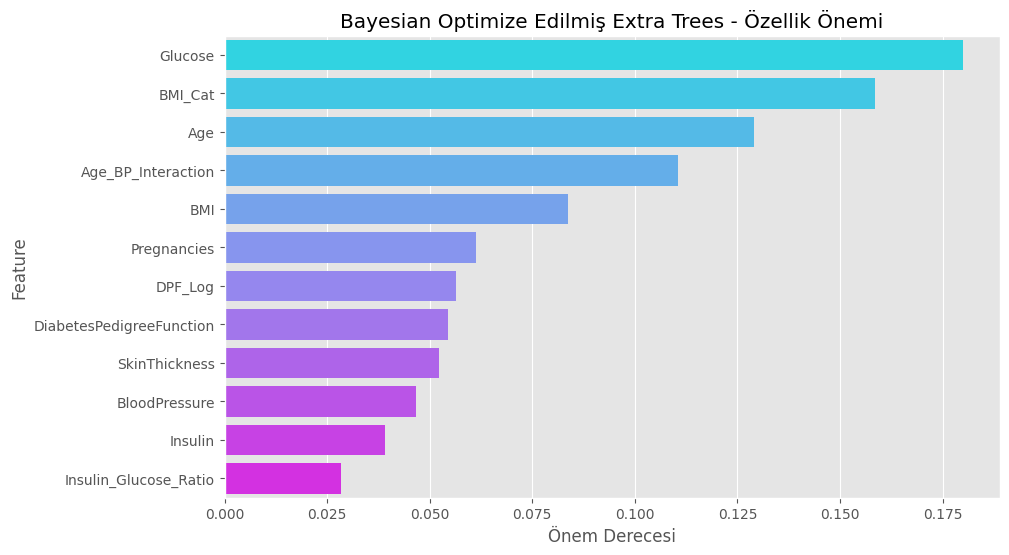

In [ ]:
# =============================================================================
# EXTRA TREES İLE BAYESIAN OPTIMIZATION
# =============================================================================
from sklearn.ensemble import ExtraTreesClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer # Parametre uzayı için
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

param_space = {
    'n_estimators': Integer(100, 500),
    'max_depth': Integer(5, 50),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'criterion': Categorical(['gini', 'entropy']),
    'bootstrap': Categorical([True, False])
}

print("Bayesian Optimization Başlatılıyor... (Akıllı Arama)")

opt = BayesSearchCV(
    estimator=ExtraTreesClassifier(random_state=42, n_jobs=-1),
    search_spaces=param_space,
    n_iter=32,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

opt.fit(X_train, y_train)

best_et_model = opt.best_estimator_

print(f"\n--- BAYESIAN OPTİMİZASYON SONUCU ---")
print(f"En İyi Parametreler: {opt.best_params_}")
print(f"Eğitim Setindeki En İyi Skor: %{opt.best_score_ * 100:.2f}")

y_pred_best_et = best_et_model.predict(X_test)
acc_best_et = accuracy_score(y_test, y_pred_best_et)
f1_best_et = f1_score(y_test, y_pred_best_et)

print(f"\n===== OPTİMİZE EXTRA TREES SONUÇLARI =====")
print(f"Doğruluk (Accuracy): %{acc_best_et * 100:.2f}")
print(f"F1 Skoru           : %{f1_best_et * 100:.2f}")
print("\n--- Detaylı Rapor ---")
print(classification_report(y_test, y_pred_best_et, target_names=['Sağlıklı', 'Diyabet']))

feature_importance_et = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_et_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_et, palette='cool')
plt.title('Bayesian Optimize Edilmiş Extra Trees - Özellik Önemi')
plt.xlabel('Önem Derecesi')
plt.show()


===== FİNAL KARŞILAŞTIRMA TABLOSU =====
                    Model   Accuracy   F1 Score
0                CatBoost  89.578164  87.931034
1  Extra Trees (Bayesian)  89.081886  87.283237


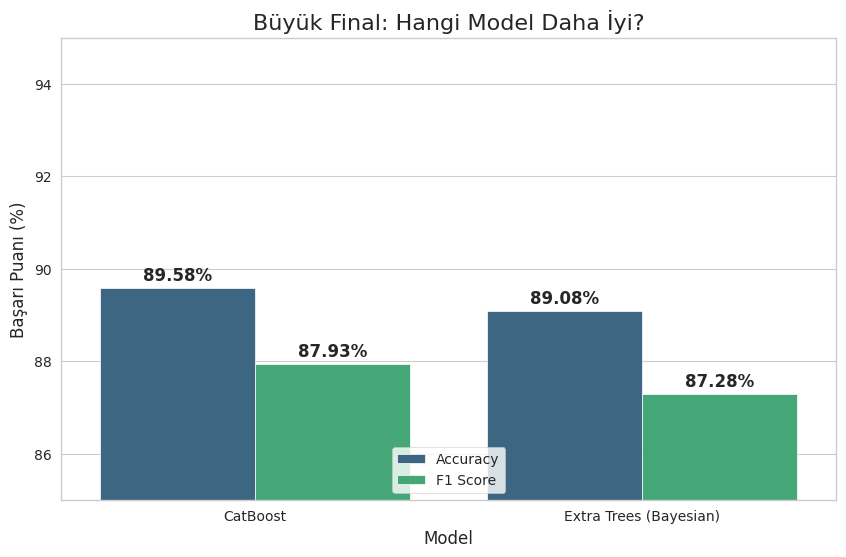


🏆 ŞAMPİYON BELLİ OLDU!
🥇 Kazanan: CATBOOST (Fark: %0.50)
✅ Öneri: Simülasyon ve gerçek kullanım için CatBoost modeli tercih edilmelidir.


In [ ]:
# =============================================================================
# CATBOOST vs BAYESIAN EXTRA TREES
# =============================================================================
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

results = pd.DataFrame({
    'Model': ['CatBoost', 'Extra Trees (Bayesian)'],
    'Accuracy': [acc * 100, acc_best_et * 100],
    'F1 Score': [f1 * 100, f1_best_et * 100]
})

print("\n===== FİNAL KARŞILAŞTIRMA TABLOSU =====")
print(results)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

results_melted = results.melt(id_vars="Model", var_name="Metric", value_name="Score")

ax = sns.barplot(x="Model", y="Score", hue="Metric", data=results_melted, palette="viridis")

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', padding=3, fontsize=12, fontweight='bold')

plt.title("Büyük Final: Hangi Model Daha İyi?", fontsize=16)
plt.ylabel("Başarı Puanı (%)")
plt.ylim(85, 95)
plt.legend(loc='lower center')
plt.show()

print(f"\n🏆 ŞAMPİYON BELLİ OLDU!")
if acc > acc_best_et:
    print(f"🥇 Kazanan: CATBOOST (Fark: %{acc*100 - acc_best_et*100:.2f})")
    print("✅ Öneri: Simülasyon ve gerçek kullanım için CatBoost modeli tercih edilmelidir.")
else:
    print(f"🥇 Kazanan: EXTRA TREES (Fark: %{acc_best_et*100 - acc*100:.2f})")

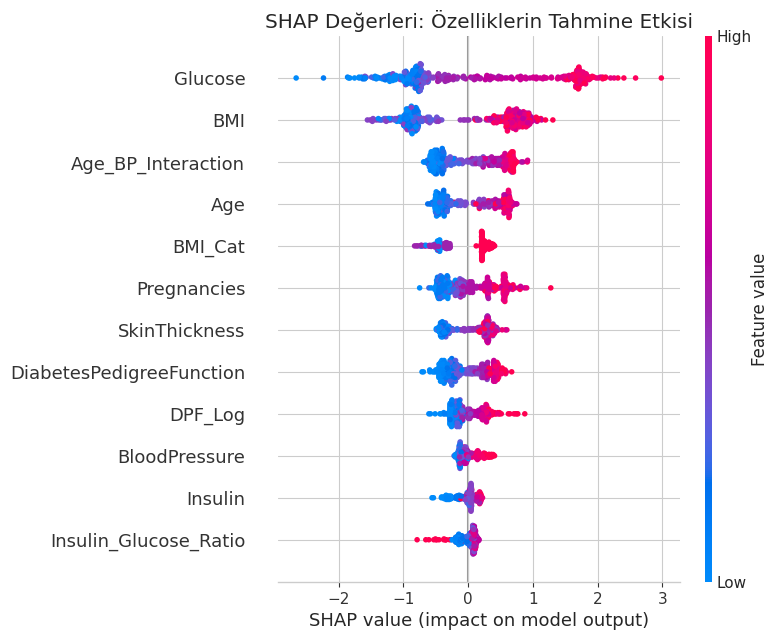

In [ ]:
import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Değerleri: Özelliklerin Tahmine Etkisi")
plt.show()

In [ ]:
import gradio as gr
import pandas as pd
import numpy as np

# Hangi model hafızadaysa onu seçiyoruz
# Eğer 'best_et_model' yoksa hata almamak için kontrol ediyoruz
if 'best_et_model' in globals():
    aktif_model = best_et_model
elif 'catboost_model' in globals():
    aktif_model = catboost_model
else:
    print("UYARI: Hiçbir model bulunamadı! Lütfen önce model eğitim kodunu çalıştırın.")

def arayuz_tahmin(pregnancies, glucose, blood_pressure, skin_thickness, insulin, bmi, dpf, age):

    try:
        # 1. ARKA PLAN HESAPLAMALARI (Feature Engineering)
        if bmi < 18.5: bmi_cat = 0
        elif bmi < 25: bmi_cat = 1
        elif bmi < 30: bmi_cat = 2
        else: bmi_cat = 3

        insulin_glucose_ratio = insulin / (glucose + 0.1)
        age_bp_interaction = age * blood_pressure
        dpf_log = np.log1p(dpf) # Bu hesaplama vardı ama aşağıya eklenmemişti

        # 2. VERİ PAKETLEME (Eksik satır buraya eklendi!)
        input_data = pd.DataFrame({
            'Pregnancies': [pregnancies],
            'Glucose': [glucose],
            'BloodPressure': [blood_pressure],
            'SkinThickness': [skin_thickness],
            'Insulin': [insulin],
            'BMI': [bmi],
            'DiabetesPedigreeFunction': [dpf],
            'Age': [age],
            'BMI_Cat': [bmi_cat],
            'Insulin_Glucose_Ratio': [insulin_glucose_ratio],
            'Age_BP_Interaction': [age_bp_interaction],
            'DPF_Log': [dpf_log]  # <--- İŞTE EKSİK OLAN KRİTİK SATIR BU!
        })

        # 3. TAHMİN
        prediction = aktif_model.predict(input_data)[0]
        probability = aktif_model.predict_proba(input_data)[0][1]
        risk_yuzdesi = probability * 100

        # 4. RAPORLAMA
        if prediction == 1:
            baslik = "⚠️ RİSK TESPİT EDİLDİ!"
        else:
            baslik = "✅ SONUÇ NEGATİF (SAĞLIKLI)"

        rapor = (f"{baslik}\n"
                 f"{'-'*30}\n"
                 f"Diyabet İhtimali: %{risk_yuzdesi:.2f}\n\n"
                 f"--- TEKNİK DETAYLAR ---\n"
                 f"• Obezite Kategorisi: {bmi_cat}\n"
                 f"• Yaş x Tansiyon Skoru: {age_bp_interaction}\n"
                 f"• Genetik Skor (Log): {dpf_log:.2f}")

        return rapor

    except Exception as e:
        # Hata olursa ekrana hatanın sebebini yazdırır
        return f"HATA OLUŞTU: {str(e)}\n\nLütfen modelin hafızada yüklü olduğundan emin olun."

# ARAYÜZ AYARLARI
demo = gr.Interface(
    fn=arayuz_tahmin,
    inputs=[
        gr.Number(label="Hamilelik (Pregnancies)", value=0),
        gr.Slider(0, 200, label="Glikoz (Glucose)", value=100),
        gr.Number(label="Tansiyon (BloodPressure)", value=70),
        gr.Number(label="Cilt Kalınlığı", value=20),
        gr.Number(label="İnsülin", value=79),
        gr.Number(label="BMI", value=25.0),
        gr.Number(label="DPF (Genetik - Örn: 0.5)", value=0.5),
        gr.Slider(0, 100, label="Yaş", value=30)
    ],
    outputs=gr.Textbox(label="Sonuç Raporu", lines=10),
    title="🚑 Diyabet Risk Simülasyonu",
    description="Değerleri girin ve 'Submit' butonuna basın."
)

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://80c5d418e662a86da5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
